In [281]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('test_out.csv', sep=',', header=0)

In [282]:
train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)


In [283]:
def getData(store_num):
    train = pd.concat([train1, train2, train3, train4], ignore_index=True)
    train = train[train['store_nbr'] == store_num]
    train = train.drop(columns=["id", "store_nbr"], axis=1)
    train_data = train.pivot_table(index=['date'], columns="family", values='sales')
    train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
    data = train_data
    return data

In [284]:
def dataSplit(data, bounds):
    train = data.iloc[:bounds, -1].values
    test = data.iloc[bounds:, -1].values
    return train, test

In [285]:
sc = MinMaxScaler(feature_range=(0,1))

def transform_data(data, sequence_length):
    data = np.array(data)
    data = data.reshape(-1,1)
    data_scaled = sc.fit_transform(data)

    data_x = []
    data_y = []

    for i in range(sequence_length, len(data) ):
        data_x.append(data_scaled[i-sequence_length:i, 0])
        data_y.append(data_scaled[i,0])

    data_x, data_y = np.array(data_x), np.array(data_y)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1))

    return data_x, data_y

In [286]:
def createModel(train_x, num_units, activation_func, reg_strength, learning_rate):
    model = Sequential()
    
    model.add(LSTM(units=num_units, return_sequences=True, input_shape=(train_x.shape[1], 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    model.add(LSTM(units=num_units,
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='msle')
    
    return model
    


In [287]:
def trainModel(model, train_x, train_y, num_epochs, batch_size):
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size)

In [288]:
def predict(test_data, model):
    pred = model.predict(test_data)
    pred = sc.inverse_transform(pred)
    return pred 

In [289]:
def plot(test, pred,title):
    plt.plot(test, color='red', label='Real Values')
    plt.plot(pred, color='blue', label='Predicted Values')
    plt.title('Model vs.' + title)
    plt.xlabel('Days after our last training day')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [290]:
# Set bounds for data
bounds = 1300

# Get data
store_num = 1
data = getData(store_num)

# Train and test data
train_data , test_data = dataSplit(data, bounds)

# Transform data
sequence_length = 7
train_x, train_y = transform_data(train_data, sequence_length)
test_x, test_y = transform_data(test_data, sequence_length)

# Initial conditions for model
num_units = 140
activation_func = 'linear'
reg_strength = 0.00
learning_rate = 0.00001

#Create model
model = createModel(train_x,num_units, activation_func, reg_strength, learning_rate)


In [291]:
# Train conditions
num_epochs = 15
batch_size = sequence_length*3

In [292]:
# Train model with store #1

# Train model
trainModel(model, train_x, train_y, num_epochs, batch_size)

Epoch 1/15
62/62 [==============================] - 2s 11ms/step - loss: 0.0979
Epoch 2/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0967
Epoch 3/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0953
Epoch 4/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0933
Epoch 5/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0906
Epoch 6/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0870
Epoch 7/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0819
Epoch 8/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0748
Epoch 9/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0651
Epoch 10/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0534
Epoch 11/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0433
Epoch 12/15
62/62 [==============================] - 1s 12ms/step - loss: 0.0393
Epoch 13/15
62/62 [==================

In [293]:
# Train model with store #3

# Get data
store_num = 3
data = getData(store_num)

# Train and test data
train_data , test_data = dataSplit(data, bounds)

# Transform data
train_x, train_y = transform_data(train_data, sequence_length)
test_x, test_y = transform_data(test_data, sequence_length)

# Train model
trainModel(model, train_x, train_y, num_epochs, batch_size)


Epoch 1/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0435
Epoch 2/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0434
Epoch 3/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0434
Epoch 4/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0433
Epoch 5/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0433
Epoch 6/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0433
Epoch 7/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0433
Epoch 8/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0433
Epoch 9/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0432
Epoch 10/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0432
Epoch 11/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0432
Epoch 12/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0432
Epoch 13/15
62/62 [==================

In [294]:
# Train model with store #10

# Get data
store_num = 10
data = getData(store_num)

# Train and test data
train_data , test_data = dataSplit(data, bounds)

# Transform data
sequence_length = 7
train_x, train_y = transform_data(train_data, sequence_length)
test_x, test_y = transform_data(test_data, sequence_length)

# Train model
trainModel(model, train_x, train_y, num_epochs, batch_size)

Epoch 1/15
62/62 [==============================] - 1s 12ms/step - loss: 0.0202
Epoch 2/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 3/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0201
Epoch 4/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0201
Epoch 5/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 6/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0201
Epoch 7/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 8/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 9/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 10/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 11/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 12/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0201
Epoch 13/15
62/62 [==================

In [295]:
# Train model with store 17

# Get data
store_num = 17
data = getData(store_num)

# Train and test data
train_data , test_data = dataSplit(data, bounds)

# Transform data
train_x, train_y = transform_data(train_data, sequence_length)
test_x, test_y = transform_data(test_data, sequence_length)

# Train model
trainModel(model, train_x, train_y, num_epochs, batch_size)

Epoch 1/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0308
Epoch 2/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 3/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 4/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 5/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 6/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 7/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0307
Epoch 8/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0307
Epoch 9/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 10/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 11/15
62/62 [==============================] - 1s 10ms/step - loss: 0.0307
Epoch 12/15
62/62 [==============================] - 1s 11ms/step - loss: 0.0307
Epoch 13/15
62/62 [==================

12/12 [==============================] - 0s 4ms/step


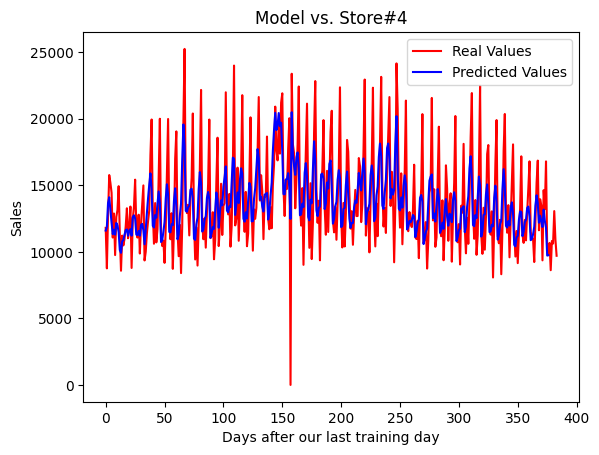

In [296]:
# Here we are going to see how our model can predict store #4
# Get data
store_num = 4
data = getData(store_num)
train_data , test_data = dataSplit(data, bounds)

# Transform data
test_x, test_y = transform_data(test_data, sequence_length)

# Predict with test data
pred = predict(test_x, model)
pred = pred[:, 1]

# Plot the data
title = " Store#4"
plot(test_data, abs(pred), title)